# Importing all the conversations

This is a bit trickier as you need to do something with all the conversations you're loading up.

In [97]:
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull
import datetime
import json
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import textwrap
from matplotlib.dates import DateFormatter
from matplotlib.dates import HourLocator 


In [98]:

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.sans-serif']=['Segoe UI Emoji']

In [118]:
pickle_name = "all_convo.pickle" 
pickle_path = Path(pickle_name)


SyntaxError: cannot assign to literal (<ipython-input-118-5aadb6b4576a>, line 1)

In [100]:
punctuation_regex = r"""
               [,.;:-@#?!&$/\(\)\n\*]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """
STOP_WORDS = [
        "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "did", "do", "does", "doing", "don", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "her", "here", "hers", "herself", "him", "himself", "his", "how", "http", "https", "i", "i'd", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "just", "me", "more", "most", "my", "myself", "no", "nor", "not", "now", "of", "off", "on", "once", "only", "or", "other", "our", "ours", "ourselves", "out", "over", "own", "s", "same", "she", "should", "so", "some", "such", "t", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "were", "what", "when", "where", "which", "while", "who", "whom", "why", "will", "with", "you", "your", "yours", "yourself", "yourselves", "nan", # not a word, accidental cast of NaN
    ]  # https://gist.github.com/sebleier/554280

In [101]:
def parse_obj(obj):
    for key in obj:
        if isinstance(obj[key], str):
            obj[key] = obj[key].encode("latin_1").decode("utf-8")
        elif isinstance(obj[key], list):
            obj[key] = list(
                map(
                    lambda x: x
                    if type(x) != str
                    else x.encode("latin_1").decode("utf-8"),
                    obj[key],
                )
            )
        pass
    return obj


def sumarise_convo(name, data, verbose=False):
    words = {}
    words[name] = data.content.str.cat(sep=" ")
    wordcount = len(words[name].split(" "))

    unique_words = set(words[name].split(" "))

    pool = " ".join([str(x) for x in data.content.to_list()]).lower() 
    clean = re.sub(
        punctuation_regex, " ", pool, flags=re.VERBOSE
    )  # and replace it with a single space
    stopped = list(set([w for w in clean.split() if w not in STOP_WORDS]))

    if verbose:
        print(
            f"{name} wrote {wordcount} words ({len(words[name])} characters)"
            f" and used {len(stopped)} different words."
        )
    return {
        "participant": name,
        "wordcount": wordcount,
        "unique_words": len(unique_words),
        "cleaned_unique": len(stopped),
    }

In [102]:
rootdir = "fb_data/messages/inbox"
conversations = []
for d in os.listdir(rootdir):
    conversations.append(d)
print(f"There are {len(conversations)} conversations to look at.")
# conversations


There are 191 conversations to look at.


In [103]:
def get_message_length(message):
    if type(message) is str:
        return len(message)
    else:
        return len(str(message))


def replace_typographic_apostrophy(message):
    if type(message) is str:
        return message.replace("’", "'")
    else:
        return message


convo_df_list = []

# print(f"\n{name}")
# participants = []
if not pickle_path.is_file():
    for convo in os.listdir(rootdir):
        for f in os.listdir(os.path.join(rootdir, convo)):
            try:
                message_list = []
                path = os.path.join(os.path.join(rootdir, convo, f))
                if Path(path).is_file():
                    with open(path, "r") as insta_data:
                        messages = json.load(insta_data, object_hook=parse_obj)
                        message_list.extend(messages["messages"])

                # print(message_list)
                if len(message_list) != 0:
                    df = pd.DataFrame(message_list)
                    df["source_convo"] = convo
                    df["datetime"] = df.timestamp_ms.apply(
                        lambda x: datetime.datetime.fromtimestamp(x / 1000.0)
                    )
                    if "content" in df.columns:
                        df["messages_length"] = df.content.apply(get_message_length)
                        df.content = df.content.apply(replace_typographic_apostrophy)
                    else:
                        df["message_length"] = 0
                        df["content"] = np.nan

                    convo_df_list.append(df)

            except Exception as e:
                print("excption", convo, e)


In [104]:
if pickle_path.is_file():
    all_convo_df = pd.read_pickle(pickle_path)
else:
    all_convo_df = pd.concat(convo_df_list)
    pd.to_pickle(all_convo_df, pickle_path)
    all_convo_df.sample(10)


In [105]:
def clean_and_stop(content, as_list=False):
    try:
        clean = re.sub(
        punctuation_regex,
        " ",
        content,
        flags=re.VERBOSE,  # and replace it with a single space
        )
        stopped = [w.lower() for w in clean.split() if w.lower() not in STOP_WORDS]
        # print(content, "=>", stopped)
        if as_list:
            return stopped
        else:
            return " ".join(stopped)
    except Exception as e:
        # print(content, e)
        return content

all_convo_df["clean_content"] = all_convo_df.content.apply(clean_and_stop)


In [106]:
print(all_convo_df.shape)
all_convo_df.head(5)

(39415, 20)


sender_name   timestamp_ms              content     type  is_unsent  \
0              1547017013329                    넵  Generic      False   
1         장수영  1547016964711    괜찮아요 다음부터 조심하세요~~  Generic      False   
2              1547016938868  찾았습니다... 감사합니다 정말..  Generic      False   
3              1547016812510        아지금 3층으로가고있어요  Generic      False   
4         장수영  1547016791852               찾으셨나요?  Generic      False   

  source_convo                datetime  message_length photos sticker   ip  \
0   nimxf-gelg 2019-01-09 17:56:53.329               1    NaN     NaN  NaN   
1   nimxf-gelg 2019-01-09 17:56:04.711              17    NaN     NaN  NaN   
2   nimxf-gelg 2019-01-09 17:55:38.868              19    NaN     NaN  NaN   
3   nimxf-gelg 2019-01-09 17:53:32.510              13    NaN     NaN  NaN   
4   nimxf-gelg 2019-01-09 17:53:11.852               6    NaN     NaN  NaN   

   call_duration share reactions gifs videos audio_files missed users  \
0            NaN   NaN       NaN  NaN    NaN         NaN    NaN   NaN   
1            NaN   NaN       NaN  NaN    NaN         NaN    NaN   NaN   
2            NaN   NaN       NaN  NaN    NaN         NaN    NaN   NaN   
3            NaN   NaN       NaN  NaN    NaN         NaN    NaN   NaN   
4            NaN   NaN       NaN  NaN    NaN         NaN    NaN   NaN   

       clean_content  
0                  넵  
1  괜찮아요 다음부터 조심하세요~~  
2     찾았습니다 감사합니다 정말  
3      아지금 3층으로가고있어요  
4              찾으셨나요

In [107]:
# words = {}
# for name, data in df.groupby("sender_name"):
#     words[name] = data.content.str.cat(sep=" ")
#     wordcount = len(words[name].split(" "))
#     # print(f"{name} wrote {wordcount} words ({len(words[name])} characters)")


In [108]:
conv_meta = []
for name, data in all_convo_df.groupby("sender_name"):
    conv_meta.append( sumarise_convo(name, data))
meta_df = pd.DataFrame(conv_meta)
meta_df["ratio"] = meta_df.apply(lambda row: row.wordcount / (row.cleaned_unique+1) , axis=1)


/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/

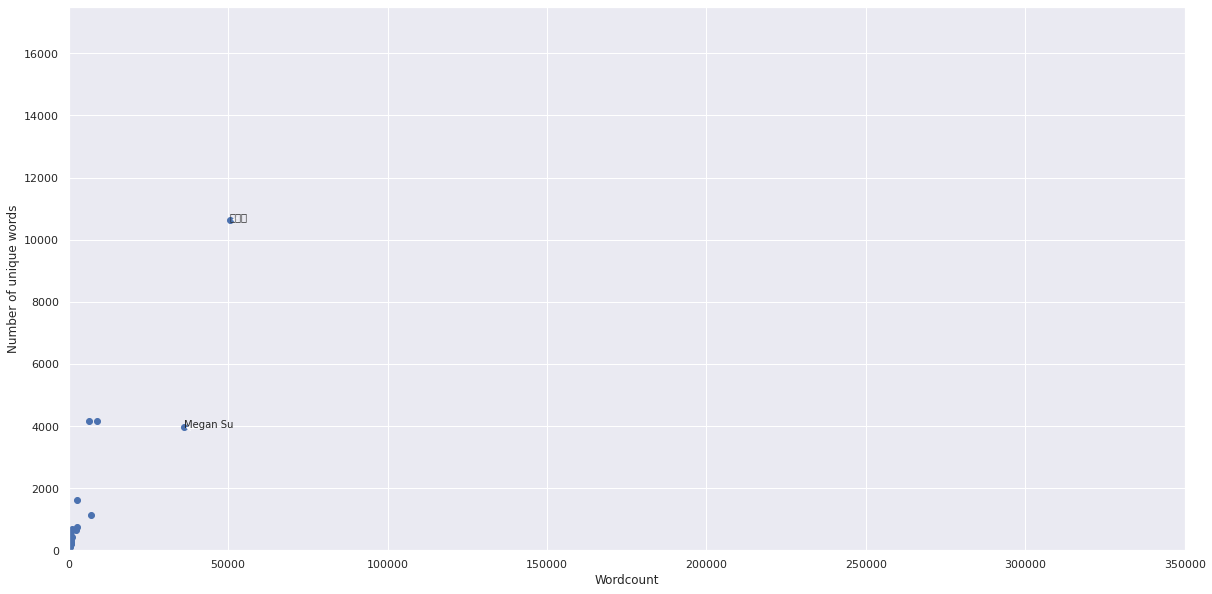

In [109]:
import random

fig = plt.figure()
ax = plt.gca()
# plt.scatter(meta_df.wordcount, meta_df.unique_words)
ax.scatter(meta_df.wordcount, meta_df.cleaned_unique)
plt.xlabel("Wordcount")
plt.ylabel("Number of unique words")
plt.xlim([0, 350000])
plt.ylim([0, 17500])

for i, row in meta_df.iterrows():
    if row.wordcount > 15000:
        # if row.wordcount > 15000:
        #     right = 60
        # else:
        #     right = 500
        plt.annotate(
            row.participant,
            (row.wordcount, row.cleaned_unique),
            size=10,
            xycoords="data",
            xytext=(
                random.randint(50, 130) * random.sample(range(-1, 1), k=1)[0],
                random.randint(50, 60) * random.sample(range(-1, 1), k=1)[0],
            ),
            textcoords="offset points",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"),
        )

# # define the true objective function
# def objective(x, a, b, c):
# 	return a * x + b * x**2 + c
# x=meta_df.wordcount
# y=meta_df.cleaned_unique
# # curve fit
# popt, _ = curve_fit(objective, x, y)
# # summarize the parameter values
# a, b, c = popt
# print('y = %.5f * x + %.5f * x^2 + %.5f' % (a, b, c))

# # define a sequence of inputs between the smallest and largest known inputs
# x_line = np.arange(min(x), max(x), 1)
# # calculate the output for the range
# y_line = objective(x_line, a, b, c)
# # create a line plot for the mapping function
# plt.plot(x_line, y_line, '--', color='red')


Text(0.5, 1.0, 'Ratio of wordcount to unique words count\n(only showing those with word counts over 1k)')

/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anacon

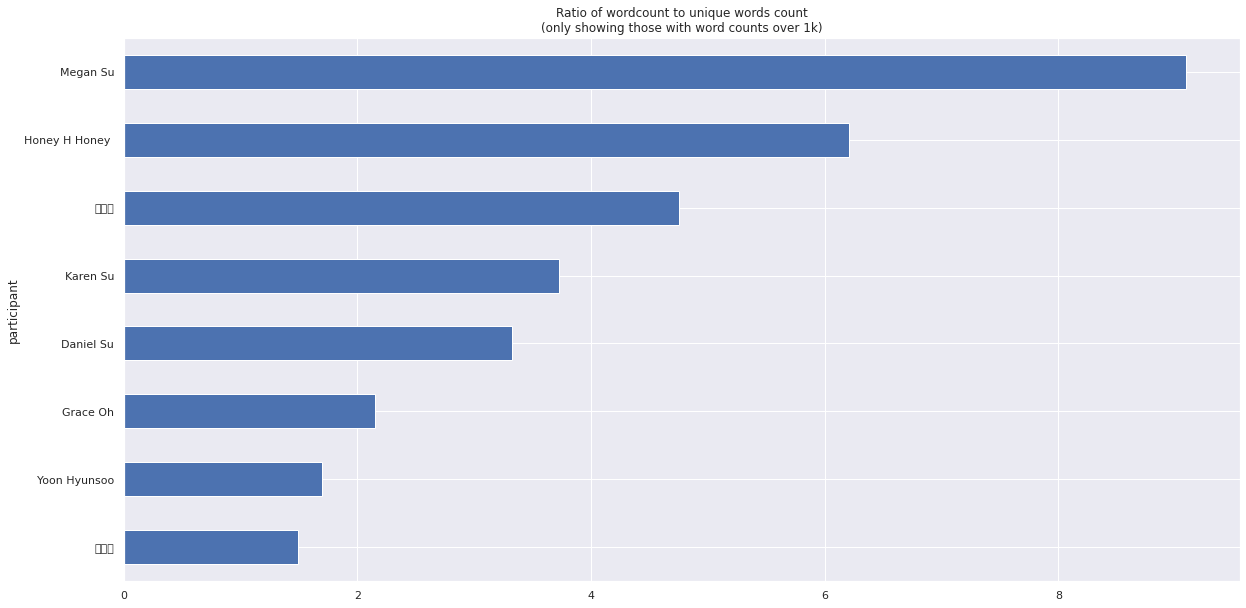

In [110]:
meta_df[meta_df.wordcount>1000].set_index("participant").ratio.sort_values().plot.barh()
plt.title("Ratio of wordcount to unique words count\n(only showing those with word counts over 1k)")

<AxesSubplot:title={'center':'Number of messages sent'}>

/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anacon

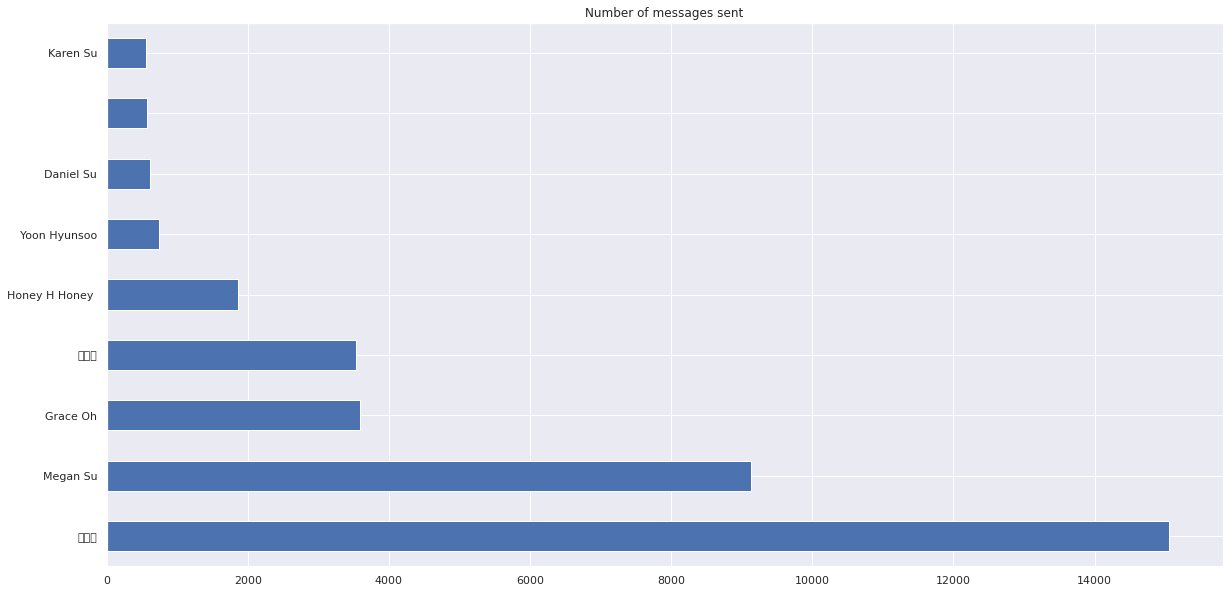

In [111]:
vc = all_convo_df.sender_name.value_counts()
vc[(vc > 500) & (vc < 100000)].plot.barh(
    title="Number of messages sent"
)  # , xlim=(0,6606834)


In [112]:
chatty_people = all_convo_df.sender_name.value_counts() > 100
all_convo_df["chatty_people"] = [chatty_people[x] for x in all_convo_df.sender_name]
all_convo_df.sample(10)


sender_name   timestamp_ms  \
11           장수영  1600054080302   
113          장수영  1589841319270   
3320         장수영  1485418570747   
3721         장수영  1609651766439   
3831         장수영  1609229100361   
673          이승영  1418203774249   
6755         장수영  1584487980377   
2202         장수영  1448052749399   
10    Other User  1442477561535   
1180         이가영  1418100979207   

                                                content     type  is_unsent  \
11    we are having party for english on next thursd...  Generic      False   
113                               Nooo all my hard work  Generic      False   
3320                                                  💩  Generic      False   
3721                                               LMAO  Generic      False   
3831                            Have u got ur roasters?  Generic      False   
673                                             가영이언니특히  Generic      False   
6755                       I said due to feeling unwell  Generic      False   
2202                                       근데 귀찬아서 누워잇음  Generic      False   
10                                        응응ㅇ뭔가 많이 변했어😆  Generic      False   
1180                                                NaN  Generic      False   

                 source_convo                datetime  message_length photos  \
11     honeyhhoney_4bagrexlvg 2020-09-14 13:28:00.302              51    NaN   
113        karensu_s1v9qvmjhw 2020-05-19 08:35:19.270              21    NaN   
3320       megansu_zepkvzqqpg 2017-01-26 19:16:10.747               1    NaN   
3721       megansu_zepkvzqqpg 2021-01-03 16:29:26.439               4    NaN   
3831       megansu_zepkvzqqpg 2020-12-29 19:05:00.361              23    NaN   
673              o_ghiwzl6v_g 2014-12-10 20:29:34.249               7    NaN   
6755       megansu_zepkvzqqpg 2020-03-18 10:33:00.377              28    NaN   
2202      igayeong_ko9r4gr9tq 2015-11-21 07:52:29.399              12    NaN   
10    facebookuser_51yhz5uweq 2015-09-17 18:12:41.535              13    NaN   
1180             o_ghiwzl6v_g 2014-12-09 15:56:19.207               3    NaN   

                                                sticker  ... call_duration  \
11                                                  NaN  ...           NaN   
113                                                 NaN  ...           NaN   
3320                                                NaN  ...           NaN   
3721                                                NaN  ...           NaN   
3831                                                NaN  ...           NaN   
673                                                 NaN  ...           NaN   
6755                                                NaN  ...           NaN   
2202                                                NaN  ...           NaN   
10                                                  NaN  ...           NaN   
1180  {'uri': 'messages/stickers_used/851575_1263621...  ...           NaN   

      share reactions gifs videos audio_files missed users  \
11      NaN       NaN  NaN    NaN         NaN    NaN   NaN   
113     NaN       NaN  NaN    NaN         NaN    NaN   NaN   
3320    NaN       NaN  NaN    NaN         NaN    NaN   NaN   
3721    NaN       NaN  NaN    NaN         NaN    NaN   NaN   
3831    NaN       NaN  NaN    NaN         NaN    NaN   NaN   
673     NaN       NaN  NaN    NaN         NaN    NaN   NaN   
6755    NaN       NaN  NaN    NaN         NaN    NaN   NaN   
2202    NaN       NaN  NaN    NaN         NaN    NaN   NaN   
10      NaN       NaN  NaN    NaN         NaN    NaN   NaN   
1180    NaN       NaN  NaN    NaN         NaN    NaN   NaN   

                       clean_content chatty_people  
11    party english next thursday p2          True  
113                   nooo hard work          True  
3320                               💩          True  
3721                            lmao          True  
3831               u got ur roasters          True  
673     

# Plotting time that might show sleep

This is a bit nasty, I don't really like it, but it seems to work. There _must_ be a better way.

Convert the time component of the datetime to just-date and just-time (but in seconds, as a number) and then plot that.

The y axis is nasty becasue it doesn't show 

In [113]:
def time_to_seconds(dt):
    t = dt.time()
    seconds = (t.hour * 60 + t.minute) * 60 + t.second
    return seconds


all_convo_df["date"] = all_convo_df.datetime.apply(lambda x: x.date())
all_convo_df["time"] = all_convo_df.datetime.apply(lambda x: x.time())
all_convo_df["seconds"] = all_convo_df.datetime.apply(time_to_seconds)
all_convo_df.sample(6)


sender_name   timestamp_ms  \
1807  Honey H Honey   1561935052124   
8062             장수영  1574228106545   
3966        Grace Oh  1495026109191   
0     Sarah Pasfield  1529409976068   
269              이가영  1492939679635   
354     Yoon Hyunsoo  1496296949626   

                                                content     type  is_unsent  \
1807                                                Yes  Generic      False   
8062              Apparently its from st George or smth  Generic      False   
3966                                                NaN  Generic      False   
0                    You are now connected on Messenger  Generic      False   
269                                                코스트코  Generic      False   
354   그러면 내가 지금 과외하러 가는데, 과외 끝나고 누나한테 물어봐서 너헌테 말해줘도 될까?  Generic      False   

                  source_convo                datetime  message_length  \
1807    honeyhhoney_4bagrexlvg 2019-07-01 08:50:52.124               3   
8062        megansu_zepkvzqqpg 2019-11-20 16:35:06.545              37   
3966        graceoh_xe0pq10crg 2017-05-17 23:01:49.191               3   
0     sarahpasfield_qy-6c3qzja 2018-06-19 22:06:16.068              34   
269        igayeong_ko9r4gr9tq 2017-04-23 19:27:59.635               4   
354     yoonhyunsoo_hm0zaf3adg 2017-06-01 16:02:29.626              49   

                                                 photos sticker  ... gifs  \
1807                                                NaN     NaN  ...  NaN   
8062                                                NaN     NaN  ...  NaN   
3966  [{'uri': 'messages/inbox/graceoh_xe0pq10crg/ph...     NaN  ...  NaN   
0                                                   NaN     NaN  ...  NaN   
269                                                 NaN     NaN  ...  NaN   
354                                                 NaN     NaN  ...  NaN   

      videos audio_files missed users  \
1807     NaN         NaN    NaN   NaN   
8062     NaN         NaN    NaN   NaN   
3966     NaN         NaN    NaN   NaN   
0        NaN         NaN    NaN   NaN   
269      NaN         NaN    NaN   NaN   
354      NaN         NaN    NaN   NaN   

                                        clean_content chatty_people  \
1807                                              yes          True   
8062                        apparently st george smth          True   
3966                                              NaN          True   
0                                 connected messenger         False   
269                                              코스트코          True   
354   그러면 내가 지금 과외하러 가는데 과외 끝나고 누나한테 물어봐서 너헌테 말해줘도 될까          True   

            date             time seconds  
1807  2019-07-01  08:50:52.124000   31852  
8062  2019-11-20  16:35:06.545000   59706  
3966  2017-05-17  23:01:49.191000   82909  
0     2018-06-19  22:06:16.068000   79576  
269   2017-04-23  19:27:59.635000   70079  
354   2017-06-01  16:02:29.626000   57749  

[6 rows x 24 columns]

NameError: name 'y' is not defined

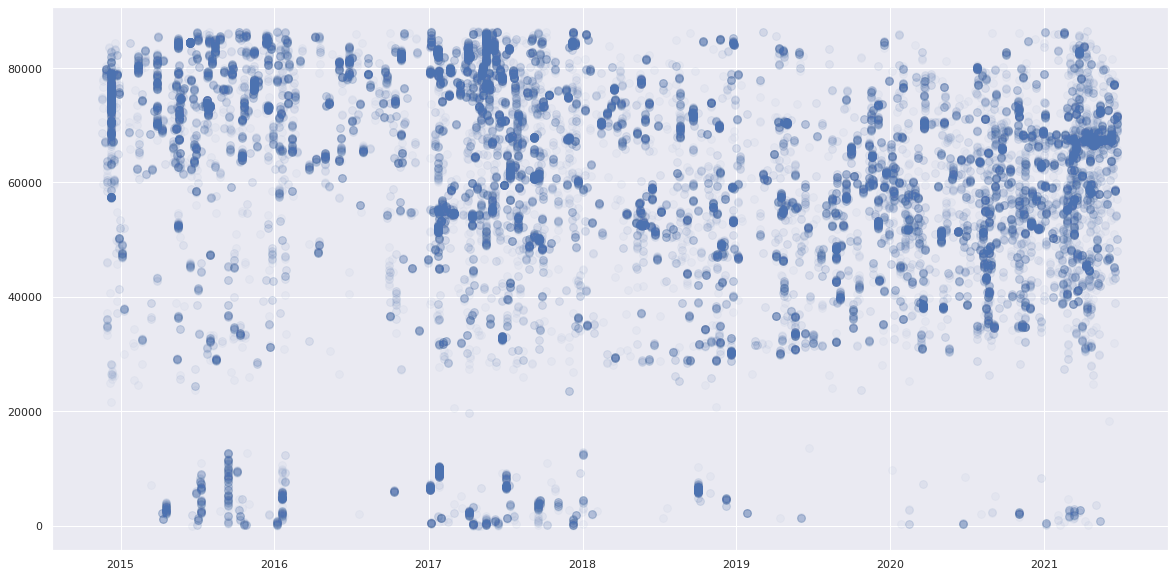

In [114]:
#Attempt to put timeframe on y-axis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter( 
    all_convo_df.date, all_convo_df.seconds, s=60, alpha=0.04
)
ax.plot(df.index, y)
ax.yaxis.set_major_locator(HourLocator()) 
ax.yaxis.set_major_formatter(DateFormatter('%H:%M'))
fig.autofmt_xdate()
plt.show()

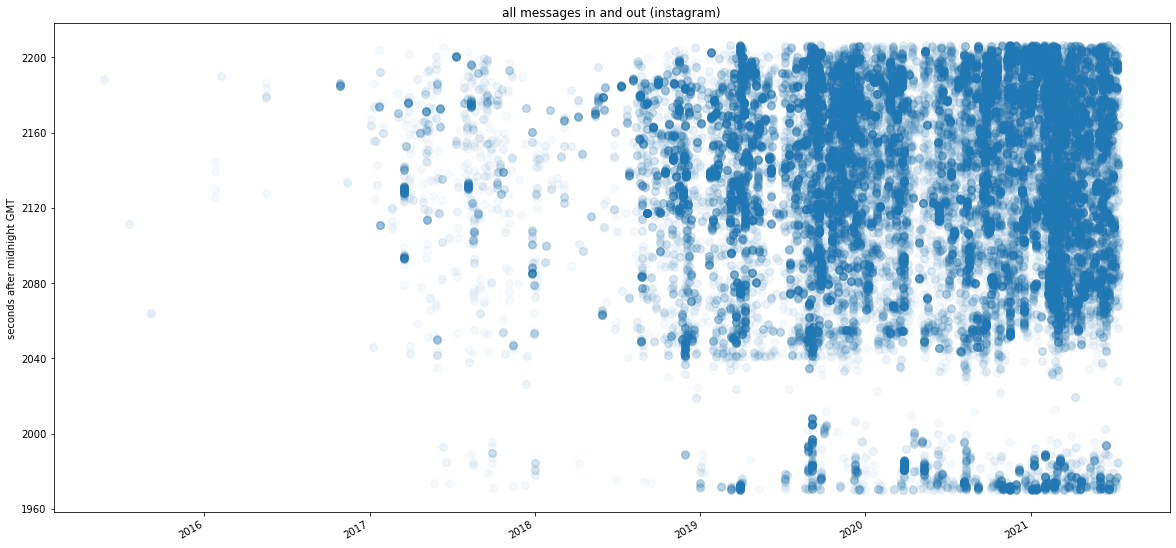

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(
    all_convo_df.date, all_convo_df.seconds, s=60, alpha=0.04
)  # , c=df.sender_name.astype('category').cat.codes)
ax.yaxis_date()
fig.autofmt_xdate()
plt.title("all messages in and out (instagram)")
plt.ylabel("seconds after midnight GMT")

plt.show()


So, this makes sense to me, but it's a bit gross. The y axis is all messed up, it should be showing time, not number of seconds. I'm also not sure if time goes forward up or down the page.

It'd be good to work out a way of identifying sleep periods. Maybe that's a period that starts after 10pm that's offline for more than 4 hours?

/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/l

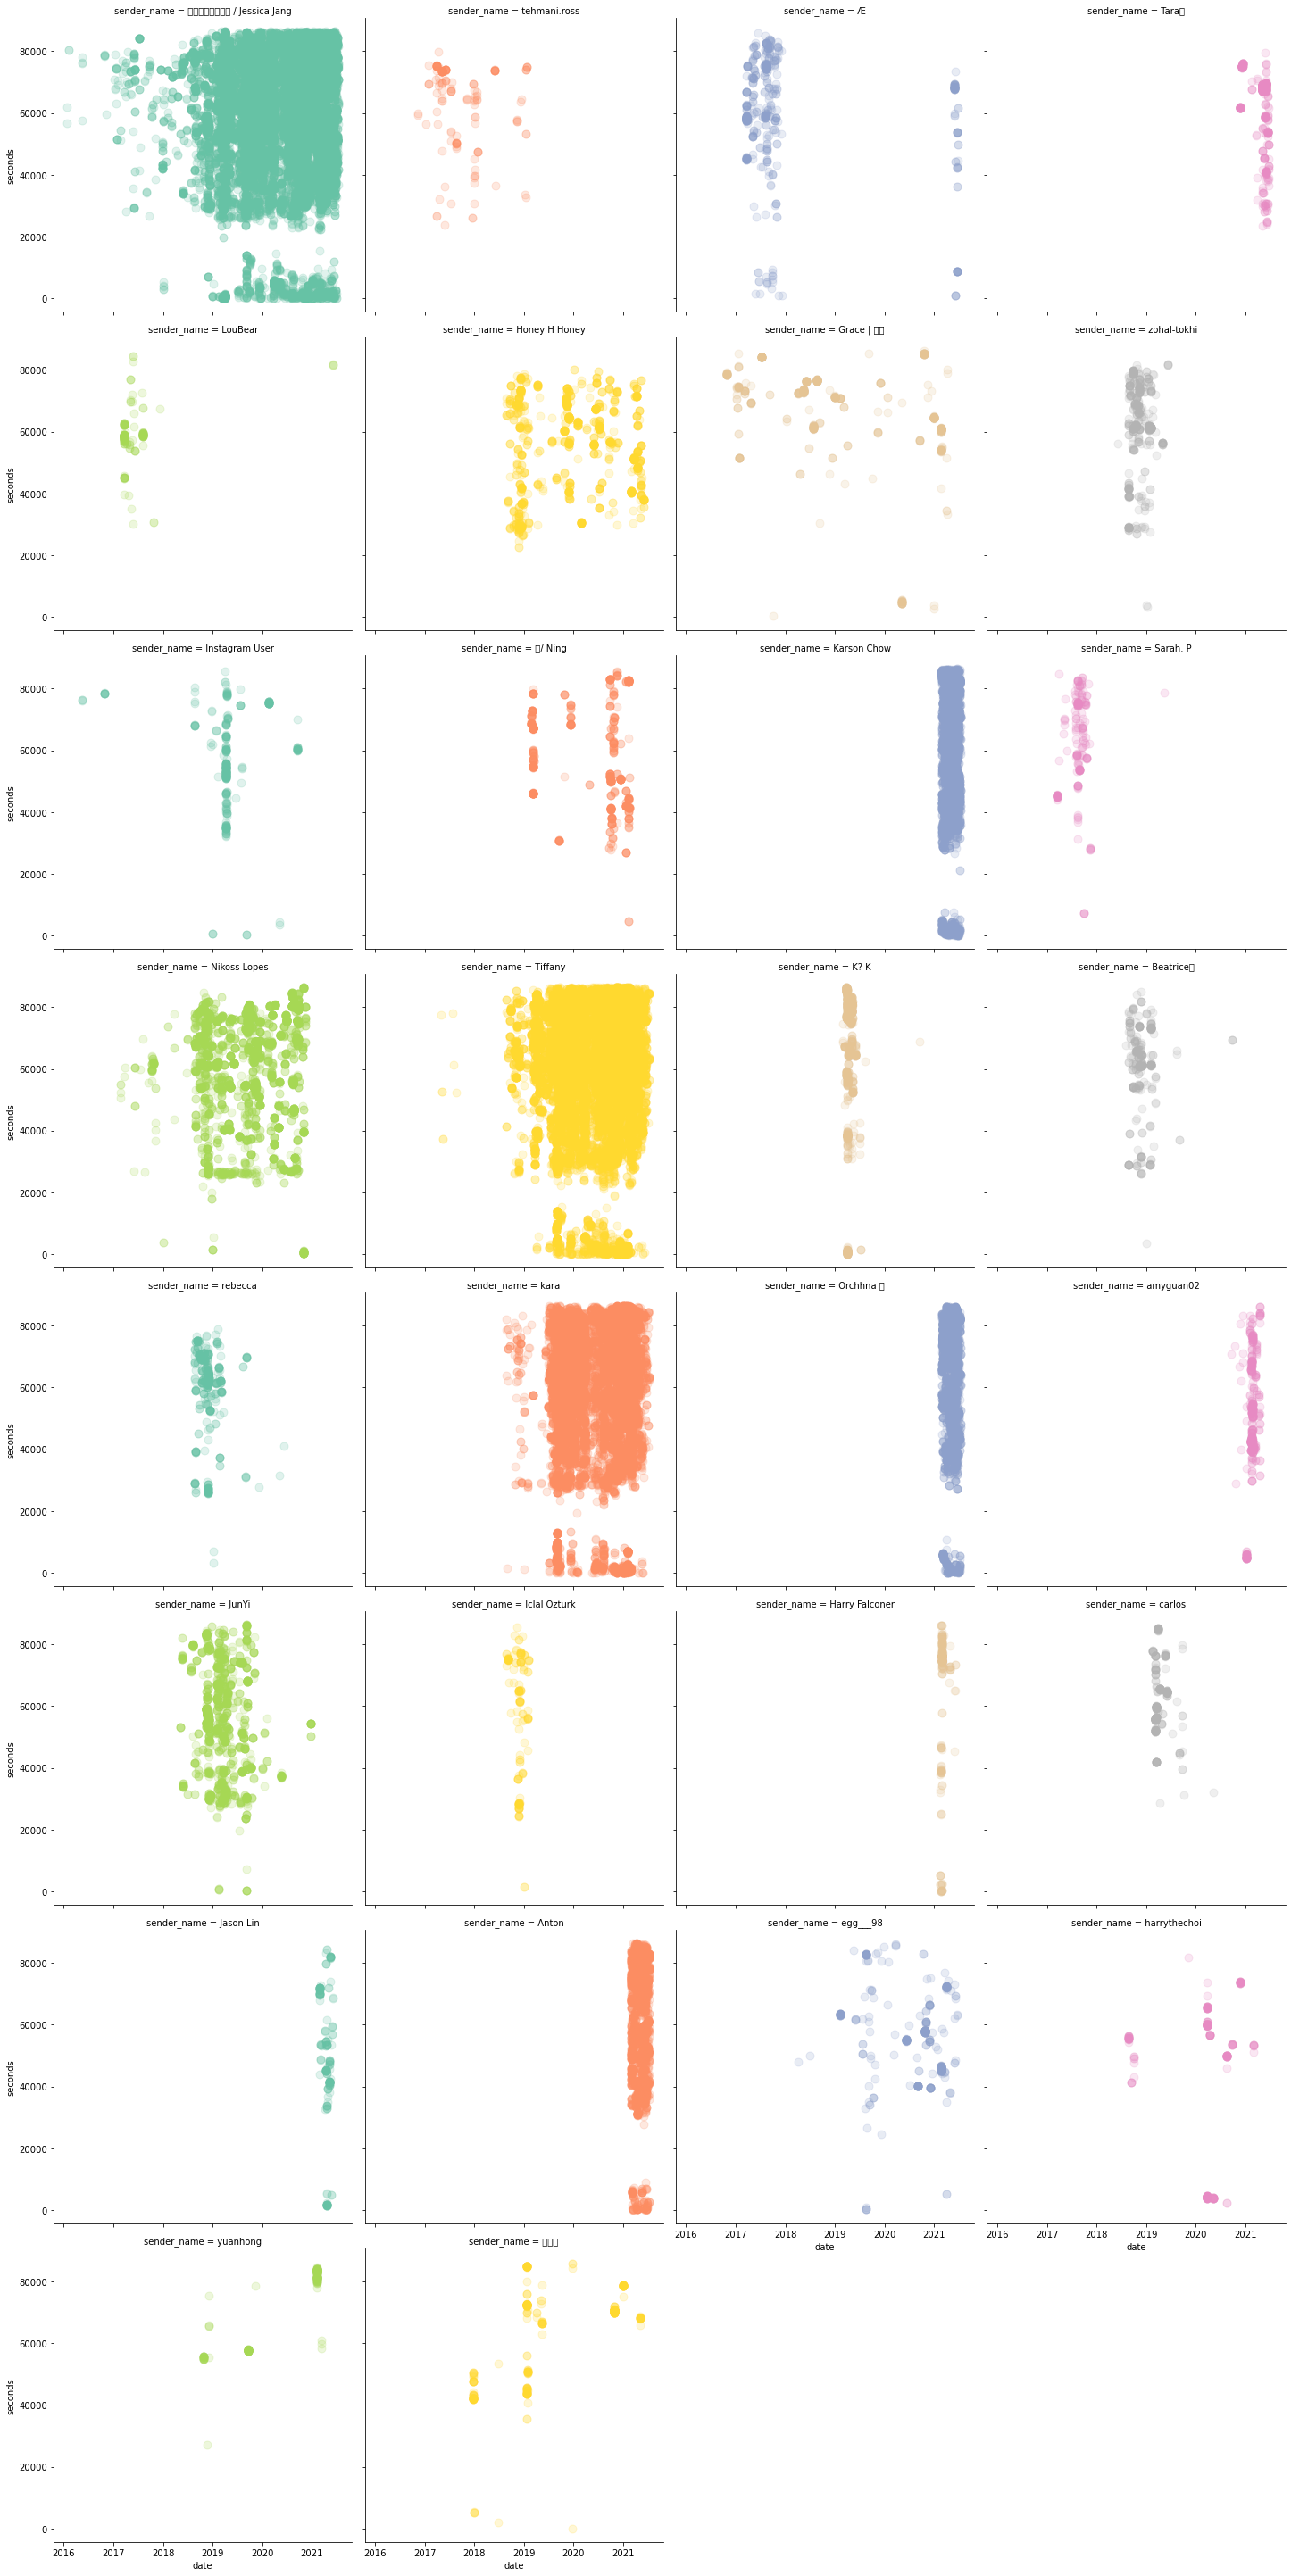

In [ ]:
plot = sns.lmplot(
    x="date",
    y="seconds",
    data=all_convo_df[all_convo_df["chatty_people"]],
    # data=all_convo_df,
    hue="sender_name",
    fit_reg=False,
    legend=True,
    palette="Set2",
    col="sender_name",
    col_wrap=4,
    scatter_kws=dict(s=80, alpha=0.2),
)


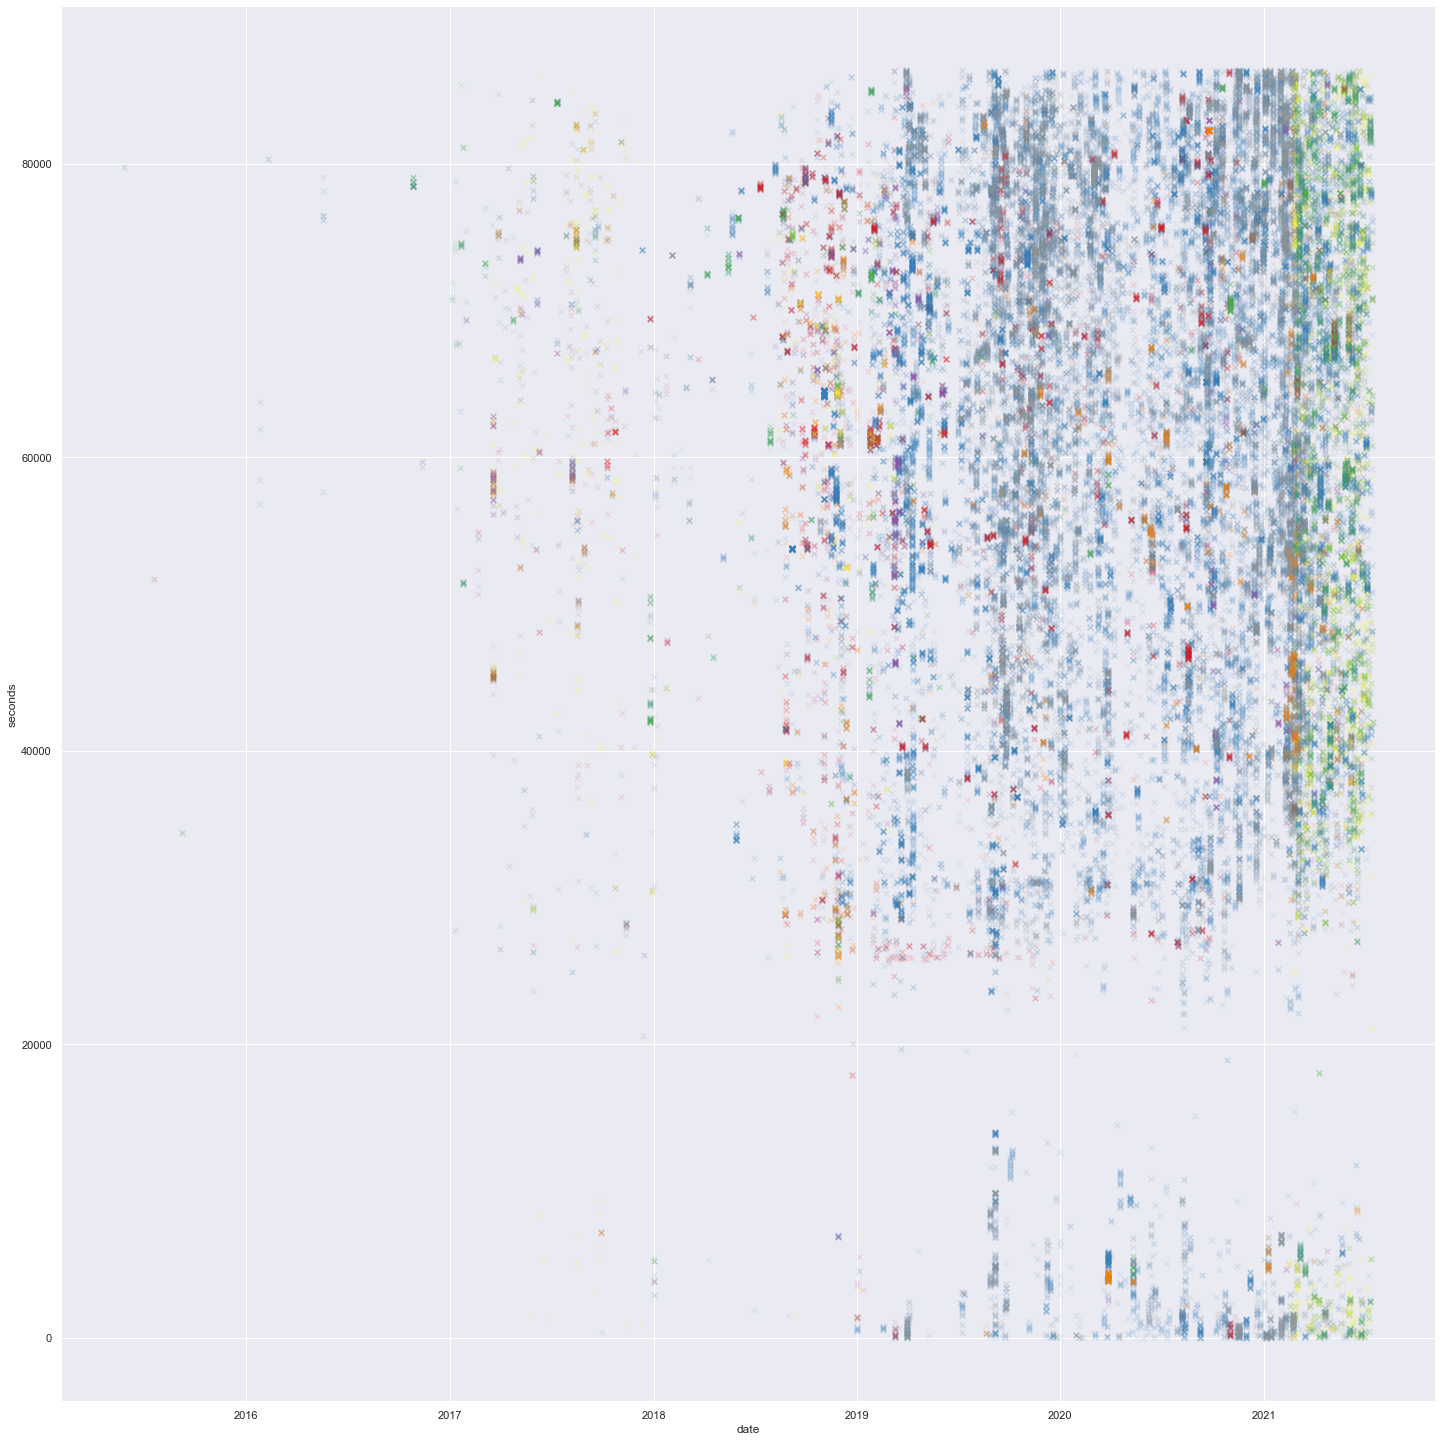

In [ ]:
sns.set(rc={"figure.figsize": (15, 15)})
plot = sns.lmplot(
    x="date",
    y="seconds",
    data=all_convo_df[all_convo_df.sender_name != "Ben Doherty"],
    hue="sender_name",
    markers="x",
    fit_reg=False,
    legend=False,
    palette="Set1",
    scatter_kws=dict(s=30, alpha=0.1),
    height=20,
    aspect=20 / 20,
)
# plt.xticks(rotation=45);
plt.savefig("all_incoming.svg")
plt.savefig("all_incoming.png")


In [ ]:
data = all_convo_df[all_convo_df.sender_name != "장수영"]
data = data[data.chatty_people]
print(data.shape)
data.sample(3)


(84390, 21)


sender_name   timestamp_ms      content     type  is_unsent  \
4417                  Tiffany  1614680835467  I might cry  Generic      False   
9656  장수영 / Jessica Jang  1584005391643          NaN  Generic      False   
7044                     kara  1574716061912          NaN  Generic      False   

                 source_convo                datetime  messages_length share  \
4417  oshirioshiri_hvg7ktd4na 2021-03-02 21:27:15.467             11.0   NaN   
9656  oshirioshiri_hvg7ktd4na 2020-03-12 20:29:51.643              3.0   NaN   
7044  oshirioshiri_hvg7ktd4na 2019-11-26 08:07:41.912              3.0   NaN   

     reactions  ... call_duration  users message_length  audio_files videos  \
4417       NaN  ...           NaN    NaN            NaN          NaN    NaN   
9656       NaN  ...           NaN    NaN            NaN          NaN    NaN   
7044       NaN  ...           NaN    NaN            NaN          NaN    NaN   

     clean_content chatty_people        date             time seconds  
4417     might cry          True  2021-03-02  21:27:15.467000   77235  
9656           NaN          True  2020-03-12  20:29:51.643000   73791  
7044           NaN          True  2019-11-26  08:07:41.912000   29261  

[3 rows x 21 columns]

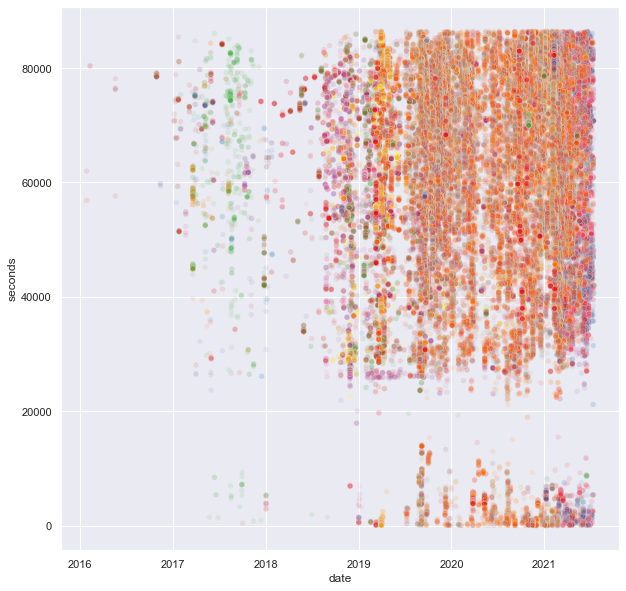

In [ ]:
sns.set(rc={"figure.figsize": (10, 10)})
fig, ax = plt.subplots()
g = sns.scatterplot(
    x="date",
    y="seconds",
    data=data,
    hue="sender_name",
    legend=False,
    palette="Set1",
    s=30,
    alpha=0.1,
    ax=ax,
)
# g.legend(bbox_to_anchor=(1.5, 1))

/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 4462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/l

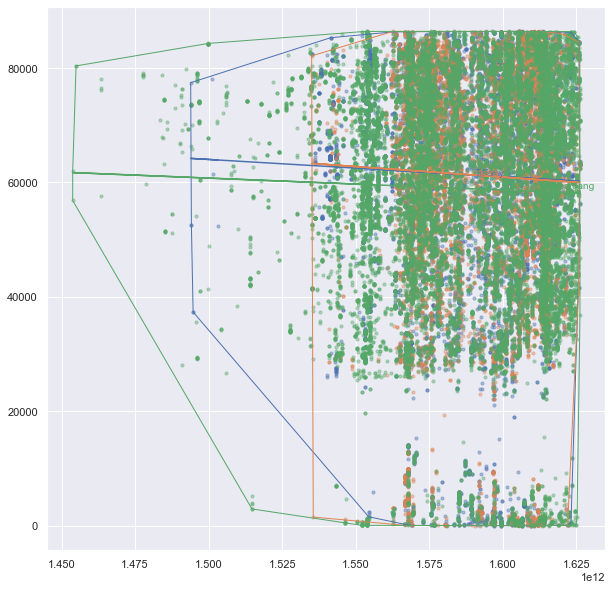

In [ ]:
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    poly = plt.Polygon(p[hull.vertices,:], **kw)
    ax.add_patch(poly)


fig, ax = plt.subplots()
for x, d in data.groupby("sender_name"):
    if d.shape[0]>4000:
        m, b = np.polyfit(d.timestamp_ms, d.seconds, 1)
        plt.plot(d.timestamp_ms, m*d.timestamp_ms + b)
        col=plt.gca().lines[-1].get_color()
        sc = ax.scatter(d.timestamp_ms, d.seconds, s=10, alpha=0.4, label=x, color=col)
        encircle(d.timestamp_ms, d.seconds, ax=ax, ec=col, fc="none")
        plt.annotate(x, (d.timestamp_ms.mean(), d.seconds.mean()), size=10, color=col)

plt.show()


ValueError: zero-size array to reduction operation fmin which has no identity

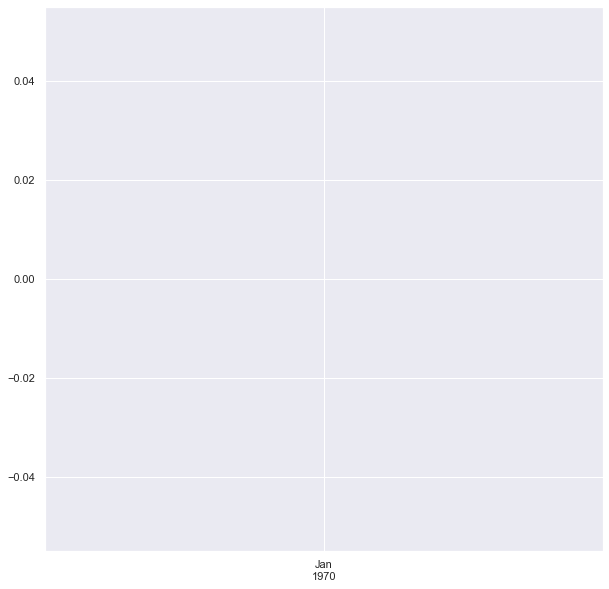

In [ ]:
bd_out_df = all_convo_df[all_convo_df.sender_name == "장수영 / Jessica Jang"]
bd_out_df.set_index("datetime").groupby(pd.Grouper(freq="M")).count().sender_name.plot()
plt.title("Messages sent per Month")

/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127803 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129416 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129419 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/sooyoungjang/opt/ana

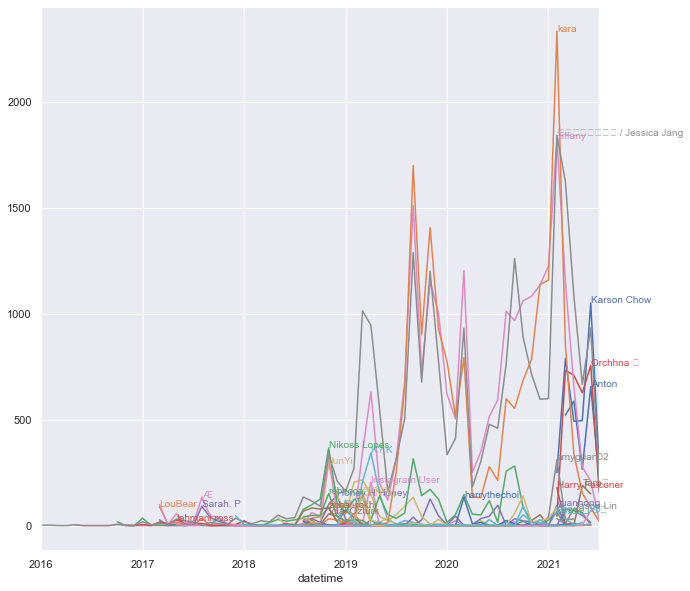

In [ ]:
fig, ax = plt.subplots()
for x, d in data.groupby("sender_name"):
    if d.shape[0]>50:
        per_period = d.set_index("datetime").groupby(pd.Grouper(freq="m")).count().sender_name
        per_period.plot()
        col=plt.gca().lines[-1].get_color()
        plt.annotate(x, (per_period.idxmax(), per_period.max()), size=10, color=col)

In [ ]:
ramen_df = all_convo_df[["" in str(x).lower() for x in all_convo_df.content]]
for name, df in ramen_df.groupby("sender_name"):
    print(name, df.shape[0])

Abbie 1
Anton 1
Betty Park 1
Dabi 1
Dabi Lee 2
Erin 3
Harry Falconer 1
Honey H Honey 12
Instagram User 2
JunYi 22
K? K 10
Karen Su 2
Karson Chow 76
Nikoss Lopes 13
Orchhna 🦈 1
Tara🦋 1
Tiffany 386
Tram Vo 1
_chuuah 1
adrian_aa268 1
carlos 1
egg___98 2
kara 236
zohal-tokhi 6
장수영 / Jessica Jang 558
고영웅 1
민동빈 1
🇬🇷 🐴 1


In [ ]:
gdf = all_convo_df[all_convo_df.sender_name=="Grace Oh"]

In [ ]:
gdf[["ㅋㅋ" in str(x).lower() for x in gdf.content]].source_convo.value_counts()

graceoh_xe0pq10crg        448
ttolm_7qmkrekacg           13
yeonghwadan_dvp4gt6elg     13
ttolasssseu_iivyeunryg      4
Name: source_convo, dtype: int64

In [ ]:
gdf = gdf.set_index("datetime")
gdf.head()

sender_name   timestamp_ms  \
datetime                                             
2017-04-09 22:50:55.398    Grace Oh  1491742255398   
2017-04-09 22:48:23.966    Grace Oh  1491742103966   
2017-04-09 22:48:23.734    Grace Oh  1491742103734   
2017-04-09 22:46:58.445    Grace Oh  1491742018445   
2017-04-09 08:12:48.552    Grace Oh  1491689568552   

                                              content     type  is_unsent  \
datetime                                                                    
2017-04-09 22:50:55.398         The video chat ended.  Generic      False   
2017-04-09 22:48:23.966  Grace joined the video chat.  Generic      False   
2017-04-09 22:48:23.734   Grace started a video chat.  Generic      False   
2017-04-09 22:46:58.445      Grace named the group 똚.  Generic      False   
2017-04-09 08:12:48.552            빨랑와 보고싶을거야 (응 아니야)  Generic      False   

                             source_convo  message_length photos sticker   ip  \
datetime                                                                        
2017-04-09 22:50:55.398  ttolm_7qmkrekacg              21    NaN     NaN  NaN   
2017-04-09 22:48:23.966  ttolm_7qmkrekacg              28    NaN     NaN  NaN   
2017-04-09 22:48:23.734  ttolm_7qmkrekacg              27    NaN     NaN  NaN   
2017-04-09 22:46:58.445  ttolm_7qmkrekacg              24    NaN     NaN  NaN   
2017-04-09 08:12:48.552  ttolm_7qmkrekacg              18    NaN     NaN  NaN   

                         ...  gifs videos audio_files missed users  \
datetime                 ...                                         
2017-04-09 22:50:55.398  ...   NaN    NaN         NaN    NaN   NaN   
2017-04-09 22:48:23.966  ...   NaN    NaN         NaN    NaN   NaN   
2017-04-09 22:48:23.734  ...   NaN    NaN         NaN    NaN   NaN   
2017-04-09 22:46:58.445  ...   NaN    NaN         NaN    NaN   NaN   
2017-04-09 08:12:48.552  ...   NaN    NaN         NaN    NaN   NaN   

                                    clean_content chatty_people        date  \
datetime                                                                      
2017-04-09 22:50:55.398          video chat ended          True  2017-04-09   
2017-04-09 22:48:23.966   grace joined video chat          True  2017-04-09   
2017-04-09 22:48:23.734  grace started video chat          True  2017-04-09   
2017-04-09 22:46:58.445       grace named group 똚          True  2017-04-09   
2017-04-09 08:12:48.552          빨랑와 보고싶을거야 응 아니야          True  2017-04-09   

                                    time  seconds  
datetime                                           
2017-04-09 22:50:55.398  22:50:55.398000    82255  
2017-04-09 22:48:23.966  22:48:23.966000    82103  
2017-04-09 22:48:23.734  22:48:23.734000    82103  
2017-04-09 22:46:58.445  22:46:58.445000    82018  
2017-04-09 08:12:48.552  08:12:48.552000    29568  

[5 rows x 23 columns]

<AxesSubplot:xlabel='datetime'>

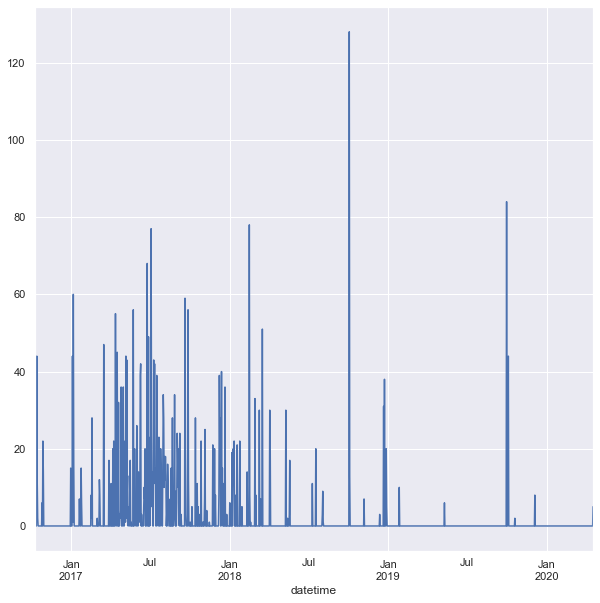

In [ ]:
gdf.groupby(pd.Grouper(freq="D")).count().sender_name.plot()

In [116]:


def has_korean(message):
    try:
        regex = r"[\uac00-\ud7af]|[\u1100-\u11ff]|[\u3130-\u318f]|[\ua960-\ua97f]|[\ud7b0-\ud7ff]"
        matches = re.match(regex, message)
        return matches is not None
    except:
        return False

print(has_korean("hello"))
print(has_korean("장수영"))
all_convo_df["isK"] = all_convo_df.content.apply(has_korean)
all_convo_df.sample(10)

False
True


sender_name   timestamp_ms                                  content  \
468            장수영  1593564297020               Did u guys take any notes?   
130            장수영  1432115996205                         Because im smart   
2543      Megan Su  1615611070945  and she missed every single ult of hers   
3154           장수영  1486127605093                   You called Badass Egg.   
690            장수영  1495079238946                                  재미없어ㅋㅋㅋ   
386      Daniel Su  1574214017317                                      idk   
2     Junhyeon Yoo  1526276463587                        부서 없오지고 나서 안가는거??   
1362           장수영  1513835563674             아 검색해보니까 ios10 이상은 가사지원이 안된데   
3789      Grace Oh  1496306479697                                      NaN   
7473           장수영  1578035646908                           I need to shit   

         type  is_unsent            source_convo                datetime  \
468   Generic      False  honeyhhoney_4bagrexlvg 2020-07-01 10:44:57.020   
130   Generic      False     liyuchen_l07czs-eoq 2015-05-20 19:59:56.205   
2543  Generic      False      megansu_zepkvzqqpg 2021-03-13 15:51:10.945   
3154     Call      False      megansu_zepkvzqqpg 2017-02-04 00:13:25.093   
690   Generic      False  yoonhyunsoo_hm0zaf3adg 2017-05-18 13:47:18.946   
386   Generic      False     danielsu_p-1lmy2wbq 2019-11-20 12:40:17.317   
2     Generic      False  junhyeonyoo_0rlitjvpwg 2018-05-14 15:41:03.587   
1362  Generic      False      graceoh_xe0pq10crg 2017-12-21 16:52:43.674   
3789  Generic      False      graceoh_xe0pq10crg 2017-06-01 18:41:19.697   
7473  Generic      False      megansu_zepkvzqqpg 2020-01-03 18:14:06.908   

      message_length                                             photos  \
468               26                                                NaN   
130               16                                                NaN   
2543              39                                                NaN   
3154              22                                                NaN   
690                7                                                NaN   
386                3                                                NaN   
2                 17                                                NaN   
1362              28                                                NaN   
3789               3  [{'uri': 'messages/inbox/graceoh_xe0pq10crg/ph...   
7473              14                                                NaN   

     sticker  ... videos  audio_files missed users  \
468      NaN  ...    NaN          NaN    NaN   NaN   
130      NaN  ...    NaN          NaN    NaN   NaN   
2543     NaN  ...    NaN          NaN    NaN   NaN   
3154     NaN  ...    NaN          NaN    NaN   NaN   
690      NaN  ...    NaN          NaN    NaN   NaN   
386      NaN  ...    NaN          NaN    NaN   NaN   
2        NaN  ...    NaN          NaN    NaN   NaN   
1362     NaN  ...    NaN          NaN    NaN   NaN   
3789     NaN  ...    NaN          NaN    NaN   NaN   
7473     NaN  ...    NaN          NaN    NaN   NaN   

                     clean_content chatty_people        date             time  \
468              u guys take notes          True  2020-07-01  10:44:57.020000   
130                       im smart          True  2015-05-20  19:59:56.205000   
2543       missed every single ult          True  2021-03-13  15:51:10.945000   
3154             called badass egg          True  2017-02-04  00:13:25.093000   
690                        재미없어ㅋㅋㅋ          True  2017-05-18  13:47:18.946000   
386                            idk          True  2019-11-20  12:40:17.317000   
2                  부서 없오지고 나서 안가는거         False  2018-05-14  15:41:03.587000   
1362  아 검색해보니까 ios10 이상은 가사지원이 안된데          True  2017-12-21  16:52:43.674000   
3789                           NaN          True  2017-06-01  18:41:19.697000   
7473                     need shit          True  2020-01-03  18:14:06.908000   

Text(0.5, 1.0, 'Korean messages through out the years')

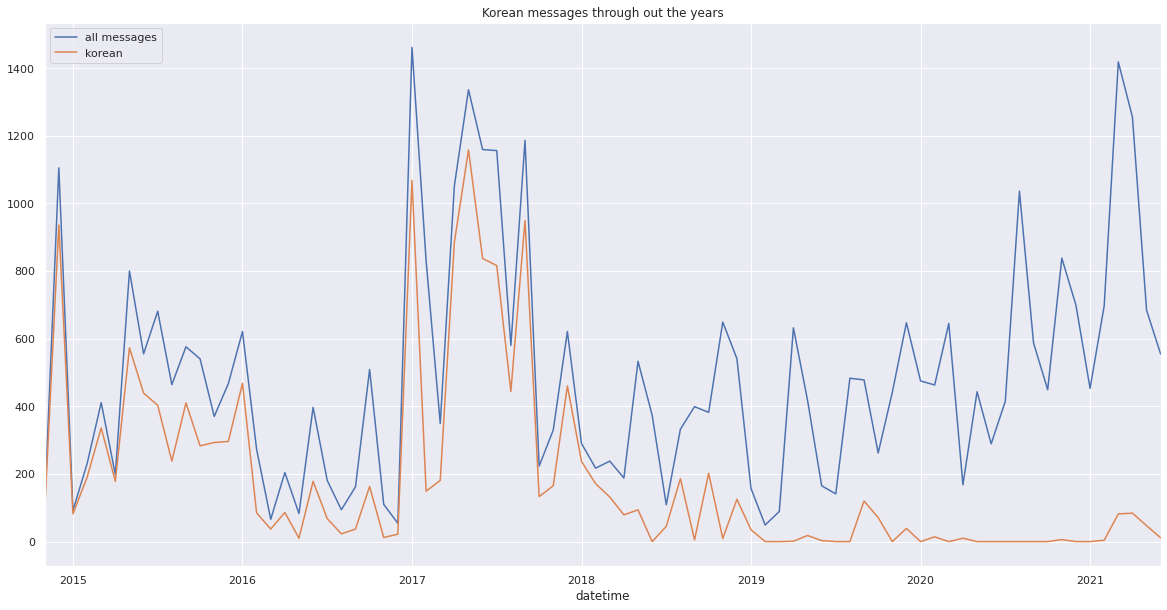

In [117]:
all_convo_df.set_index("datetime").groupby(pd.Grouper(freq="M")).count().sender_name.plot(label = "all messages")
all_convo_df[all_convo_df.isK].set_index("datetime").groupby(pd.Grouper(freq="M")).count().sender_name.plot(label = "korean")
plt.legend()
plt.title("Korean messages through out the years")